## Boilerplate

In [ ]:
# Typical imports
import numpy as np
from scipy.spatial import Delaunay
from skimage.draw import polygon2mask
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from pylab import *
import cv2
import math
import sys
print(sys.version)

# For updating my helper functions (sometimes you need to run this block twice)

In [209]:
# My own helper functions
import julians_little_helpers 
from julians_little_helpers import * 
# For reloading my helper functions when I make changes to them
import importlib
importlib.reload(julians_little_helpers)

<module 'julians_little_helpers' from '/Users/julian/Code/cs180/proj3/code/julians_little_helpers.py'>

# Part 1: Defining Correspondences
For this I chose to use a picture of myself (the photo I took for my student ID lol) and the given photo of George Clooney. 


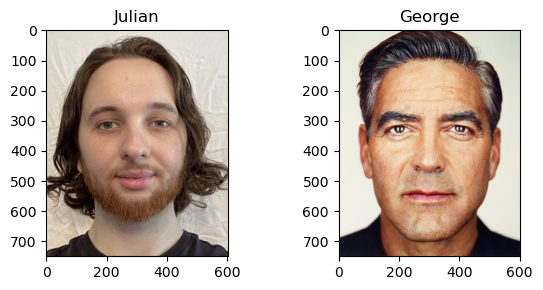

In [199]:
julian = read_im('../data/julian_portrait.jpg')
george = read_im('../data/george.jpg')
Display2Images(julian, george, 'Julian', 'George', 3)

#### Get the points I generated using this website: 
https://inst.eecs.berkeley.edu/~cs194-26/fa22/upload/files/proj3/cs194-26-aex/tool.html

(Thank you to whomever made this!)

In [ ]:
# Import the correpsondence data
julian_pts, george_pts = GetPointsFromJSON('../data/julian_portrait_george3.json')
julian_pts_xy = np.array(julian_pts)
george_pts_xy = np.array(george_pts)
# Reverse the ordering of the points from (x,y) to (y,x) 😡
julian_pts = np.column_stack((julian_pts_xy[:,1], julian_pts_xy[:,0]))
george_pts = np.column_stack((george_pts_xy[:,1], george_pts_xy[:,0]))

## Display our points and triangulations on our faces.

In [ ]:
DisplayFaceTrisAndPts(julian, GetTriangulationObject(julian_pts_xy), julian_pts, 'My original correspondences.')

In [ ]:
DisplayFaceTrisAndPts(george, GetTriangulationObject(george_pts_xy), george_pts, 'George\'s original correspondences.')

## Get the "mid-way" shape of our faces and compute its Delaunay triangulation.

In [ ]:
midway_pts = GetMidwayFace(julian_pts, george_pts)
midway_pts_xy = np.column_stack((midway_pts[:,1], midway_pts[:,0]))
midway_triangulation = Delaunay(midway_pts)

## Showing the average points and its triangulation on our faces.

In [ ]:
julian_tris = GetTriangulationObject(julian_pts)
DisplayFaceTrisAndPts(julian, GetTriangulationObjectFromExistingDelaunay(midway_pts_xy, midway_triangulation), midway_pts, 'Midway points compared to my face.')

In [ ]:
george_tris = GetTriangulationObject(george_pts)
DisplayFaceTrisAndPts(george, GetTriangulationObjectFromExistingDelaunay(midway_pts_xy, midway_triangulation), midway_pts, 'Midway points compared to george\'s face')

# Warp julian's face to george's face shape by inverse warping all pixels based on the inverse transformation matrix of the triangles they are in. 

#### Use a mask using skimage polygon and polygon2mask. You could then use the mask to select only the triangle's pixels, transform that new image, and add these up for all triangles.

In [ ]:
from scipy.spatial import Delaunay
julian_delaunay = Delaunay(julian_pts)

### How to transform each triangle's pixels? Loop through the triangles, and for each:
1. First, get a binary mask of all of the pixels in the triangle
2. Take the array slice of the image with the binary mask
3. Transform the masked image by that triangle's affine transformation to the corresponding triangle in the target image.
#### Then add up all of these images!


## Compute our delaunay triangulations.

In [ ]:
julian_delaunay = Delaunay(julian_pts)
george_delaunay = Delaunay(george_pts)

What I need to do is implement inverse warping. That means looping through all the pixels in the transformed shape, i.e. use the mask of george's triangle, and compute the coordinate in julian's image that correponds to the same point using the inverse of the transformation matrix. Because the resulting inverse coordinte is not necessarily an integer, I need to interpolate the value of the pixel at that coordinate. I can do this using bilinear interpolation.

In [ ]:
x_dim = np.arange(0, julian.shape[1])
y_dim = np.arange(0, julian.shape[0])

r_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,0], method='linear', bounds_error=False, fill_value=None)
g_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,1], method='linear', bounds_error=False, fill_value=None)
b_interpolator = RegularGridInterpolator((y_dim, x_dim), julian[:,:,2], method='linear', bounds_error=False, fill_value=None)

def interpolate_rgb(yx_coord):
    r = r_interpolator(yx_coord)
    g = g_interpolator(yx_coord)
    b = b_interpolator(yx_coord)
    return np.array((r, g, b)).reshape(1,3)

def interpolate_rgb_h(homogenous):
    return interpolate_rgb((homogenous[0], homogenous[1]))

j_tris_transformed_ims = []
masks = []
# For all triangles in the triangulation:
for i in range(len(julian_delaunay.simplices)):
    triangle_simplex = julian_delaunay.simplices[i]
    # Get the corresponding triangle shape from george's face.
    g_tri_mask_im = polygon2mask(george.shape[:2], george_pts[triangle_simplex])
    masks.append(g_tri_mask_im)
    # Compute transformation from one of my triangles to the corresponding triangle in george's face.
    j_raw_tri = julian_pts[triangle_simplex]
    g_raw_tri = george_pts[triangle_simplex]
    # Convert triangle points to homogenous coordinates.
    j_tri_pts = ConvertPointsToHomogenous(j_raw_tri)
    g_tri_pts = ConvertPointsToHomogenous(g_raw_tri)
    # Compute affine transfromation matrix from my triangle to george's triangle.
    T = ComputeAffine(j_tri_pts, g_tri_pts)
    # Get the inverse of the transformation matrix.
    T_inv = np.linalg.inv(T)

    # Initialize transformed image to zeros.
    j_tri_t = np.zeros_like(julian)
    # For every pixel coordinate position that is True in the mask of the transformed image (g_mask1)
    for y in range(g_tri_mask_im.shape[0]):
        for x in range(g_tri_mask_im.shape[1]):
            if g_tri_mask_im[y][x]:
                # Get inverse coord
                coord = np.array([y, x, 1])
                inverse_coord = T_inv @ coord
                # Interpolate the value of the pixel at the inverse_coord.
                pixel_value = interpolate_rgb_h(inverse_coord)
                # set this coord to px value of inverse_coord
                j_tri_t[y][x] = pixel_value                 
    j_tris_transformed_ims.append(j_tri_t)

julian_transformed = np.zeros_like(julian)
for im in j_tris_transformed_ims:
    julian_transformed += im
# Add up the masks
mask_weights = np.zeros_like(j_mask1)
for mask in masks:
    mask_weights += mask
mask_weights[mask_weights < 1] = 1
# Divide the result image by the mask weights (overlapping masks)
julian_transformed[:, :, 0] /= mask_weights
julian_transformed[:, :, 1] /= mask_weights
julian_transformed[:, :, 2] /= mask_weights
imshow(julian_transformed) 

In [ ]:
Display3Images(julian, george, julian_transformed, 'Julian', 'George', 'Julian transformed to George', 4)

In [ ]:
DisplayFaceTrisAndPts(julian_transformed, GetTriangulationObjectFromExistingDelaunay(george_pts_xy, george_delaunay), george_pts, 'Julian\'s face transformed to George\'s face.')

# Next task: Make some better correspance points and try to get a better result.

In [ ]:
np.clip(julian_transformed, 0, 1, out=julian_transformed)
imsave('first_decent_attempt.jpg', julian_transformed)
imshow(julian_transformed)

# Compute the morph sequence by writing a function morph(...) 

#### which will have parameters for weighting the interpolation (either more of face 1 or more of face 2). Basically, run the warping procedure we've established up until now with weighted amount of warping between the images and weighted amounts of cross-dissolving. When those variables reach 1 (starting from 0) the morph sequence will be complete.

# How do I write the morph() function?
## I have the basics down of warping one image to a different shape, as shown above, but I'm confused about the linear interpolation between "each feature pair" (as the project description says). I'm not sure what that means. I think I need to take the weighted average of all of the corresponding points. 
### What I mean is that I need to take the weighted average of the points from im1 and im2, and then use that as the points for the warped image. I think I need to do this for each triangle, and then add up all of the warped triangles to get the final warped image (like before).

In [ ]:
# Test my warp function
warp_test = warp(julian, julian_pts, george_pts, george_delaunay)

In [ ]:
imshow(warp_test)

## Cross-dissolve should be simple enough, just a linear interpolation between the pixel values of the two images.

# Turn a sequence of computed interpolated images into a GIF which shows the face morph.

# Basically, compute morph(...) for a bunch of evenly spaced weights between 0 and 1, and then use imageio to write a GIF. There should be at least 45 frames of the morph sequence and they should be played back at at least 30 frames per second.

In [210]:
# Test morph() 
morph_test = morph(julian, george, julian_pts, george_pts, midway_triangulation, 0.5, 0.5)

morph_test type: float64


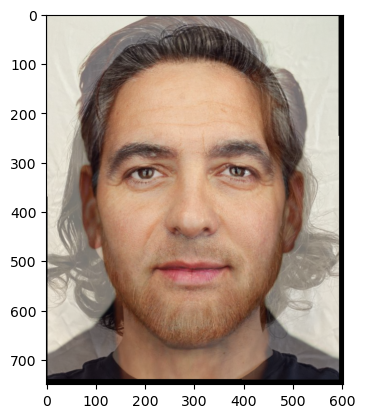

In [211]:
print(f"morph_test type: {morph_test.dtype}")
imshow(morph_test)

target_tri_pixels.shape: (28696, 2)
[[  0   1]
 [  0   2]
 [  0   3]
 ...
 [ 95 287]
 [ 95 288]
 [ 95 289]]
interpolated_rgb.shape: (28696, 3)
target_tri_pixels.shape: (39642, 2)
[[  2 592]
 [  3 592]
 [  4 592]
 ...
 [734 593]
 [735 593]
 [736 593]]
interpolated_rgb.shape: (39642, 3)
target_tri_pixels.shape: (37149, 2)
[[  0   1]
 [  4   2]
 [  5   2]
 ...
 [737   3]
 [738   3]
 [739   3]]
interpolated_rgb.shape: (37149, 3)
target_tri_pixels.shape: (14006, 2)
[[  0   1]
 [  1   3]
 [  2   4]
 ...
 [147 153]
 [148 150]
 [148 151]]
interpolated_rgb.shape: (14006, 3)
target_tri_pixels.shape: (19101, 2)
[[  0   1]
 [  1   2]
 [  2   2]
 ...
 [354 102]
 [354 103]
 [355 102]]
interpolated_rgb.shape: (19101, 3)
target_tri_pixels.shape: (24605, 2)
[[657 236]
 [657 237]
 [657 238]
 ...
 [740 589]
 [740 590]
 [740 591]]
interpolated_rgb.shape: (24605, 3)
target_tri_pixels.shape: (5756, 2)
[[653 342]
 [653 343]
 [653 344]
 ...
 [739 588]
 [739 589]
 [740 592]]
interpolated_rgb.shape: (5756, 3)
t

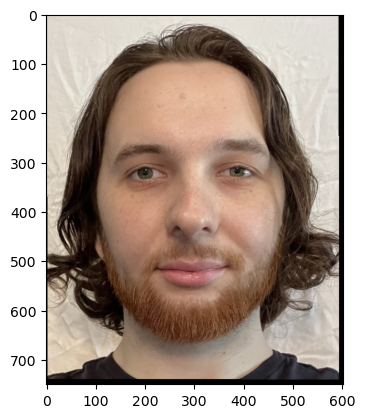

In [207]:
morph_test = morph(julian, george, julian_pts, george_pts, midway_triangulation, 0.5, 0)
imshow(morph_test)

In [ ]:
imshow(george)

target_tri_pixels.shape: (27484, 2)
[[  0   1]
 [  0   2]
 [  0   3]
 ...
 [ 91 276]
 [ 91 277]
 [ 92 274]]
interpolated_rgb.shape: (27484, 3)
target_tri_pixels.shape: (46240, 2)
[[  0 592]
 [  1 592]
 [  2 592]
 ...
 [735 593]
 [736 593]
 [740 594]]
interpolated_rgb.shape: (46240, 3)
target_tri_pixels.shape: (38833, 2)
[[  0   1]
 [  4   2]
 [  5   2]
 ...
 [737   3]
 [738   3]
 [739   3]]
interpolated_rgb.shape: (38833, 3)
target_tri_pixels.shape: (14354, 2)
[[  0   1]
 [  1   2]
 [  1   3]
 ...
 [153 147]
 [153 148]
 [154 146]]
interpolated_rgb.shape: (14354, 3)
target_tri_pixels.shape: (17162, 2)
[[  0   1]
 [  2   2]
 [  3   2]
 ...
 [347 107]
 [348 107]
 [349 107]]
interpolated_rgb.shape: (17162, 3)
target_tri_pixels.shape: (34106, 2)
[[624 245]
 [625 243]
 [625 244]
 ...
 [739 589]
 [739 590]
 [740 594]]
interpolated_rgb.shape: (34106, 3)
target_tri_pixels.shape: (6500, 2)
[[621 348]
 [622 314]
 [622 315]
 ...
 [738 589]
 [739 591]
 [740 594]]
interpolated_rgb.shape: (6500, 3)
t

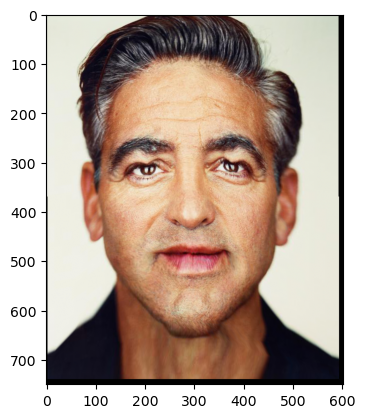

In [208]:
morph_test = morph(julian, george, julian_pts, george_pts, midway_triangulation, 0, 1)
imshow(morph_test)

In [ ]:
morph_test = morph(julian, george, julian_pts, george_pts, midway_triangulation, 0, 1.5)
imshow(morph_test)

In [ ]:
imshow(julian)

In [ ]:
morph_test = morph(julian, george, julian_pts, george_pts, midway_triangulation, 1.5, 0)
imshow(morph_test)

In [ ]:
from skimage.draw import polygon
test_tri = george_pts[george_delaunay.simplices[0]]
print(polygon(test_tri[:, 0] , test_tri[:, 1]))

In [ ]:
imageio.help('gif')

In [ ]:
frames = []
for i in range(45):
    frames.append(morph(julian, george, julian_pts, george_pts, midway_triangulation, i/44, i/44))


## Make the images uint8 and then use imageio to write a GIF.

In [ ]:
formatted_frames = []
for frame in frames:
    formatted_frames.append((frame * 255).astype(np.uint8))

In [ ]:
imshow(formatted_frames[44])

In [ ]:
# Make a gif out of the frames
import imageio
def create_gif(frames, filename, fps=30, reverse=False):
    imageio.mimwrite(filename, frames, duration=(1/fps))
# create_gif(formatted_frames, 'results/X.gif', 30, reverse=False) 

# Now get the Danes face database and import the images and their correspondances.

In [217]:
"""
@ARTICLE{Stegmann2003tmi,
         author
         title
         year
         pages
         journal
         volume
         number
         publisher
References
= "M. B. Stegmann and B. K. Ersb{\o}ll and R. Larsen",
= "{FAME} -- A Flexible Appearance Modelling Environment",
= "2003",
= "1319-1331",
= "IEEE Trans. on Medical Imaging",
= "22",
= "10",
= "IEEE"
"""

# Import the correpsondence data files.
danes_asf = {} 
import os
import glob
# Use glob to get all file paths that match the desired extension
file_paths = glob.glob(os.path.join("../data/face_data/", '*.asf'))

# Iterate over file paths and read their contents
for file_path in file_paths:
    with open(file_path, 'r') as f:
        file_name = os.path.basename(file_path)
        danes_asf[file_name] = f.read()

print(danes_asf[list(danes_asf.keys())[0]])

######################################################################
#
#    AAM Shape File  -  written: Wednesday March 07 - 2001 [11:00]
#
######################################################################

#
# number of model points
#
58

#
# model points
#
# format: <path#> <type> <x rel.> <y rel.> <point#> <connects from> <connects to>
#
0 	4 	0.35259578 	0.60584533 	0 	0 	1
0 	4 	0.35864416 	0.64749801 	1 	0 	2
0 	4 	0.37376511 	0.71199244 	2 	1 	3
0 	4 	0.39695060 	0.77111232 	3 	2 	4
0 	4 	0.43324092 	0.80604678 	4 	3 	5
0 	4 	0.45844254 	0.82351404 	5 	4 	6
0 	4 	0.48969254 	0.83426309 	6 	5 	7
0 	4 	0.53807962 	0.82217038 	7 	6 	8
0 	4 	0.56328124 	0.80201590 	8 	7 	9
0 	4 	0.59755546 	0.76976866 	9 	8 	10
0 	4 	0.61570060 	0.72945964 	10 	9 	11
0 	4 	0.62880546 	0.66899616 	11 	10 	12
0 	4 	0.64090222 	0.60718900 	12 	11 	12
1 	0 	0.60057962 	0.49835461 	13 	20 	14
1 	0 	0.58545870 	0.49029282 	14 	13 	15
1 	0 	0.57336187 	0.48357466 	15 	14 	16
1 	0 	0.55622482 	0.4876

(13, 2)


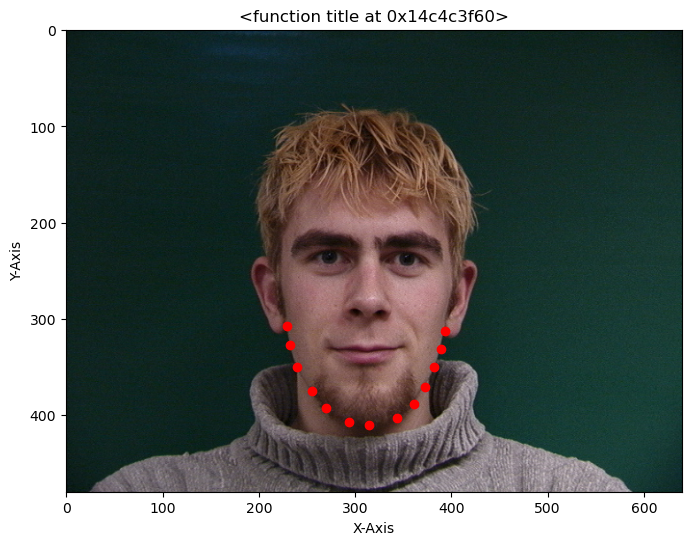

In [231]:
def parse_asf_file(file_path):
    # Dictionary to store the parsed data
    data = {
        'header': [],
        'landmarks': []
    }
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        # Find the starting line of landmarks
        start_line = -1
        for i, line in enumerate(lines):
            if line.strip().startswith("# format:"):
                start_line = i + 2  # Skip the next comment line and begin from the subsequent line
                break

        # Extract the landmarks
        for line in lines[start_line:]:
            line = line.strip()
            
            # If the line doesn't start with '0', we've reached the end of landmarks
            if not line.startswith('0'):
                break
            
            parts = line.split()
            landmark = {
                'path': int(parts[0]),
                'type': int(parts[1]),
                'x': float(parts[2]),
                'y': float(parts[3]),
                'number': int(parts[4]),
                'connects_from': int(parts[5]),
                'connects_to': int(parts[6])
            }
            data['landmarks'].append(landmark)

    return data
danes_height = 480
danes_width = 640
asf_data_01 = parse_asf_file("../data/face_data/01-1m.asf")
asf_01_points = np.array([[landmark['x'] * danes_width, landmark['y'] * danes_height] for landmark in asf_data_01['landmarks']])
dane_01 = read_im('../data/face_data/01-1m.bmp')
print(asf_01_points.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(dane_01)

ax.plot(asf_01_points[:, 0], asf_01_points[:, 1], 'ro')

ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_title(title)

plt.show()

(13, 2)


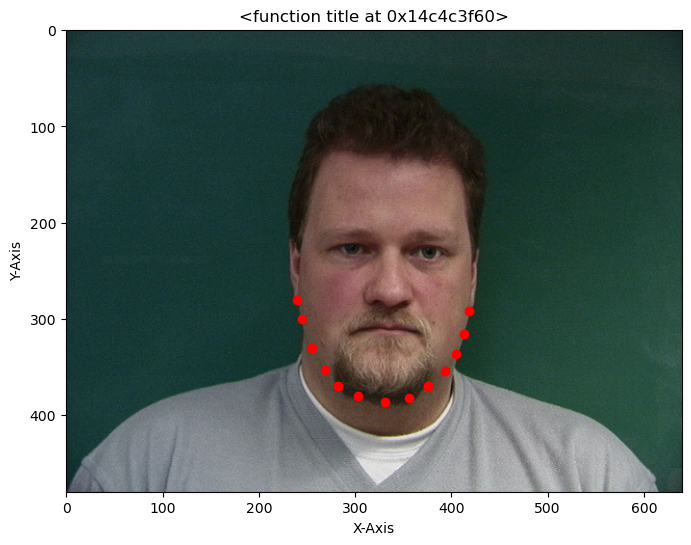

In [234]:
asf_data_05 = parse_asf_file("../data/face_data/05-1m.asf")
asf_05_points = np.array([[landmark['x'] * danes_width, landmark['y'] * danes_height] for landmark in asf_data_05['landmarks']])
dane_01 = read_im('../data/face_data/05-1m.bmp')
print(asf_05_points.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(dane_01)

ax.plot(asf_05_points[:, 0], asf_05_points[:, 1], 'ro')

ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_title(title)

plt.show()

(58, 2)


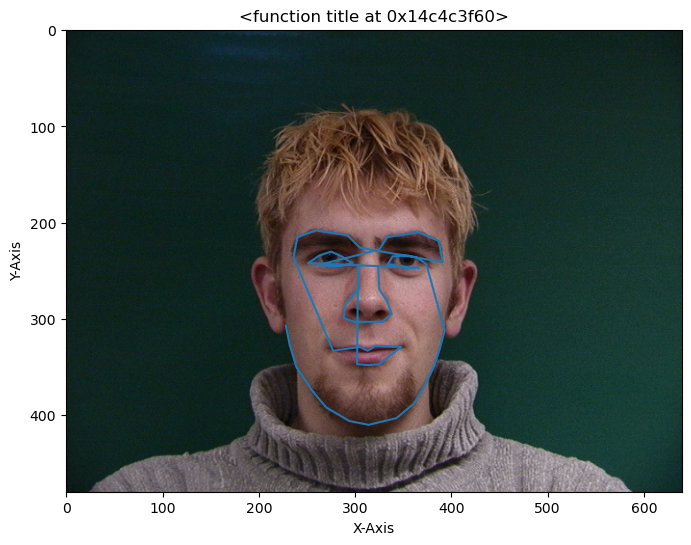

In [249]:
from collections import defaultdict
def extract_landmarks(file_path):
    landmarks = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        
        # Finding the starting line for landmarks
        start_line = -1
        for i, line in enumerate(lines):
            if line.strip().startswith("# format:"):
                start_line = i + 2
                break

        # Extracting the landmarks
        for line in lines[start_line:]:
            line = line.strip()
            
            # If the line is empty or doesn't start with a number (0-6, representing paths), skip it
            if not line or not line[0].isdigit():
                continue
            
            parts = line.split()
            # Ensure there are at least 7 parts in the split line to avoid errors
            if len(parts) < 7:
                continue
            
            landmark = {
                'path': int(parts[0]),
                'type': int(parts[1]),
                'x': float(parts[2]),
                'y': float(parts[3]),
                'number': int(parts[4]),
                'connects_from': int(parts[5]),
                'connects_to': int(parts[6])
            }
            landmarks.append(landmark)
    
    return landmarks

# Extracting all landmarks from the .asf file
all_landmarks = extract_landmarks("../data/face_data//01-1m.asf")

# Grouping the extracted landmarks by path
grouped_landmarks = defaultdict(list)
for landmark in all_landmarks:
    grouped_landmarks[landmark['path']].append(landmark)

# Displaying the count of landmarks for each path to verify extraction
landmark_counts = {path: len(landmarks) for path, landmarks in grouped_landmarks.items()}

asf_01_points = np.array([[landmark['x'] * danes_width, landmark['y'] * danes_height] for landmark in all_landmarks]).astype(int)
dane_01 = read_im('../data/face_data/01-1m.bmp')
print(asf_01_points.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(dane_01)

ax.plot(asf_01_points[:, 0], asf_01_points[:, 1], markersize=1)

ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_title(title)

plt.show()

(58, 2)


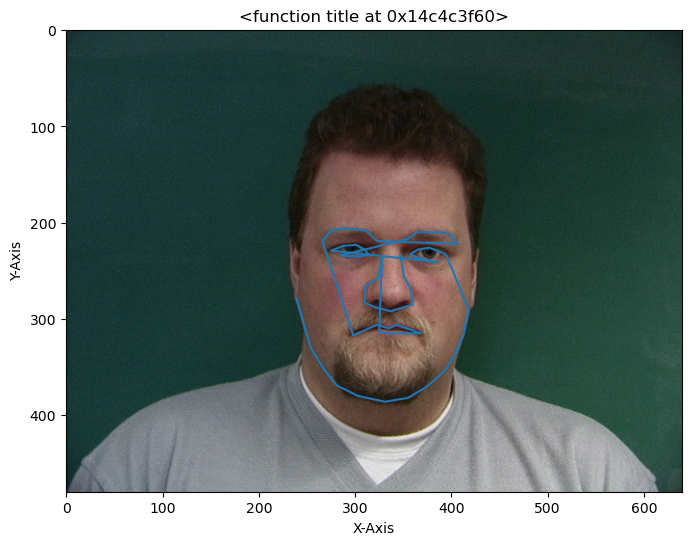

In [251]:
all_landmarks = extract_landmarks("../data/face_data/05-1m.asf")

# Grouping the extracted landmarks by path
grouped_landmarks = defaultdict(list)
for landmark in all_landmarks:
    grouped_landmarks[landmark['path']].append(landmark)

# Displaying the count of landmarks for each path to verify extraction
landmark_counts = {path: len(landmarks) for path, landmarks in grouped_landmarks.items()}

asf_01_points = np.array([[landmark['x'] * danes_width, landmark['y'] * danes_height] for landmark in all_landmarks]).astype(int)
dane_01 = read_im('../data/face_data/05-1m.bmp')
print(asf_01_points.shape)

fig, ax = plt.subplots(figsize=(8, 6))
ax.imshow(dane_01)

ax.plot(asf_01_points[:, 0], asf_01_points[:, 1], markersize=1)

ax.set_xlabel('X-Axis')
ax.set_ylabel('Y-Axis')
ax.set_title(title)

plt.show()

# Ah, I discovered that the Dane's points are in order of correspondance! This is great!!

## Here's what I need to do for te Dane's dataset (Part 4):
- Write a function to import the raw data.
- Write a function to extract the points from the raw data 
- Write a function that imports all of the images
- Take the average of all of the points and store that in a variable
- Warp all of the Dane's to the average shape, output images into a subfolder
- BONUS compute the morph sequence from each Dane to the next until it wraps around to the original dane
- Warp my face to the average Dane
- Warp the average Dane to my face
- BONUS: Compute the morph sequence from my face to the average Dane and vice versa

## Here's what I need to do for Part 5: 
- Warp my face to the average Dane shape, but extrapolate.
- Experiment with different values for the extrapolation (1.1, 1.5, 2.0 etc)